# EXPLORATION_14

## 주식 예측에 도전해 보자

## Samsung

## 1. 시계열 데이터 준비
* 종가(Close)만 사용

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [31]:
print(type(ts))

<class 'pandas.core.series.Series'>


### 안정성 여부 확인

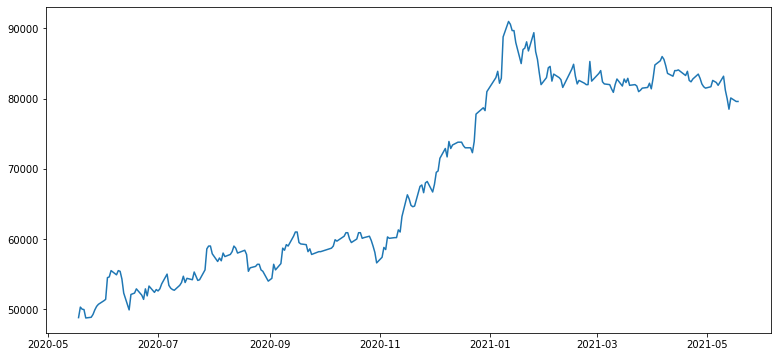

In [32]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

점점 증가하는 형태이므로 평균이 일정하지 않은 nonstationary한 데이터이다.

## 2. 각종 전처리 수행

### 결측치 처리

In [33]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없다!

In [34]:
# 결측치가 있을 경우, 결측치 처리 (보간법 사용, 기준 : time)
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

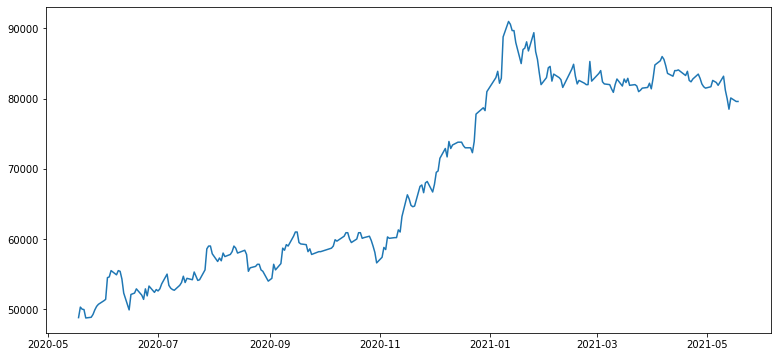

In [35]:
# 다시 그래프를 확인
plt.plot(ts)

결측치가 원래 없었으므로 그래프는 보간전후 동일하다.

### 로그 변한

In [36]:
# 로그 변환 시도 
ts_log = np.log(ts)

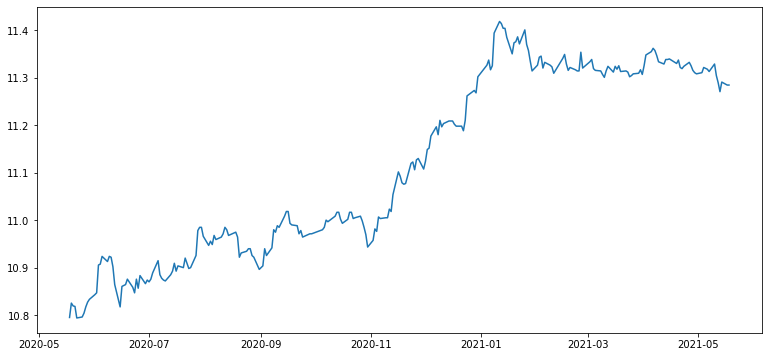

In [37]:
plt.plot(ts_log)

## 3. 시계열 안정성 분석

In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

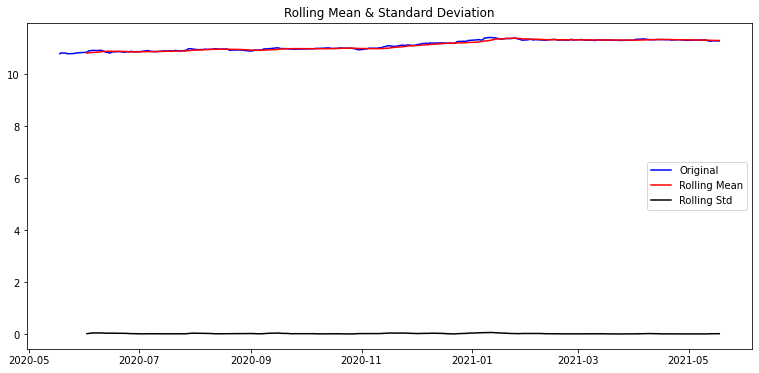

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


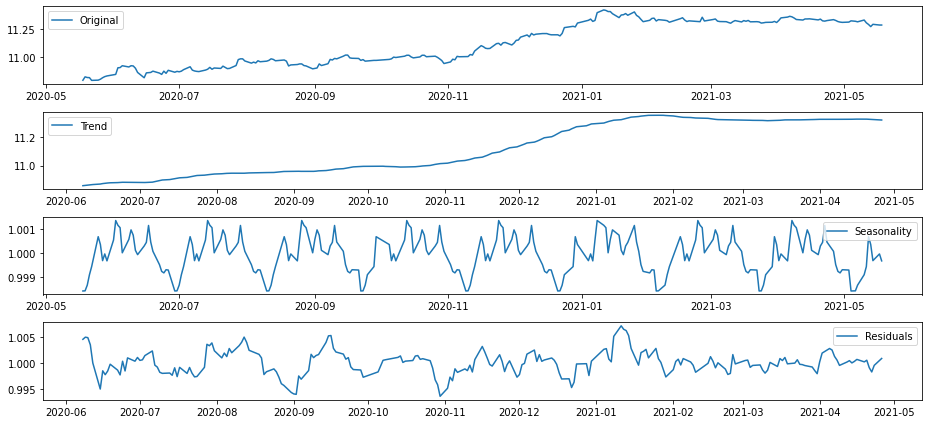

In [40]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [41]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### Dickey-Fuller Test로 stationary 여부를 체크한다!
귀무가설 : 시계열이 안정적이지 않다. <br>
대립가설 : 시계열은 안정적 시계열이다. <br>
=> p-value가 6.234854e-08이므로 0에 가깝기때문에 귀무가설은 기각, 대립가설이 채택된다.

## 4. 학습. 테이스 데이터셋 생성
* 학습, 테스트 데이터셋 분리하기

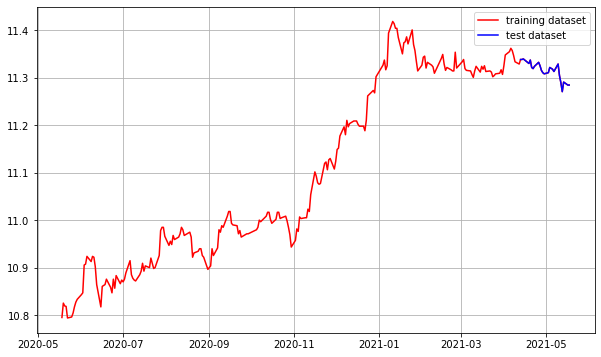

In [42]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [43]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## 5. 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

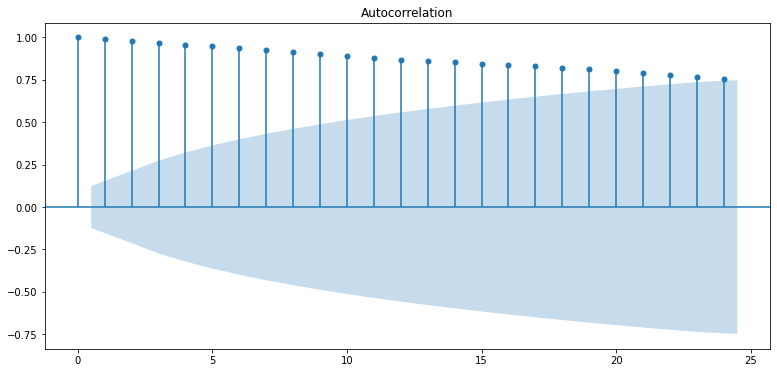

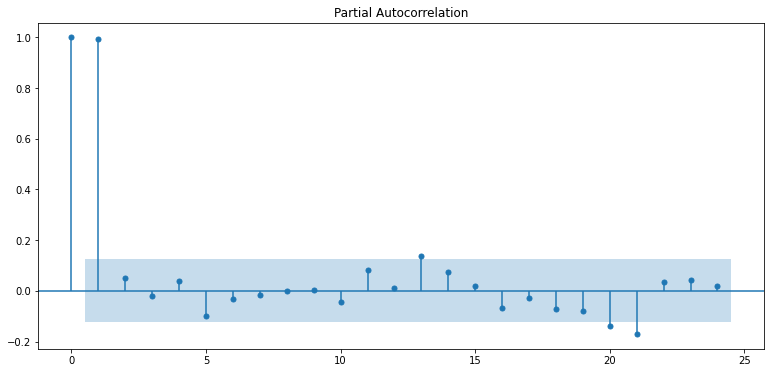

In [44]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF를 보면 일정하게 감소하고 있고, PACF를 보면 lag 1 이후에 갑자기 감소하는 것을 볼 수 있다. 
* AR/MA 모형과 ACF/PACF 관계 표를 보면 위와 같은 패턴은 AR(1)에 유사한 형태를 띄고 있다. 따라서 AR(p),MA(q)이므로 p=1, q=0 로 둘 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


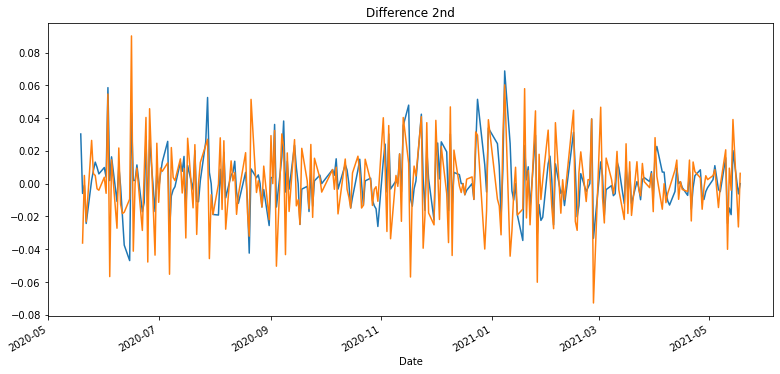

In [45]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* 1차 미분을 했을 때 p-value가 0에 충분히 가깝고 2차미분 결과와 별 차이가 없기 때문에 d=1로 둘 수 있다. 

## 6 . ARIMA 모델 훈련과 테스트

위에서 구한 파라미터인 p=1, d=1, q=0로 ARIMA(1,1,0) 모델을 돌려보겠다.

### ARIMA 모델 빌드와 훈련

In [46]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1164.792
Time:                        06:31:02   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

### 모델 테스트 및 플로팅

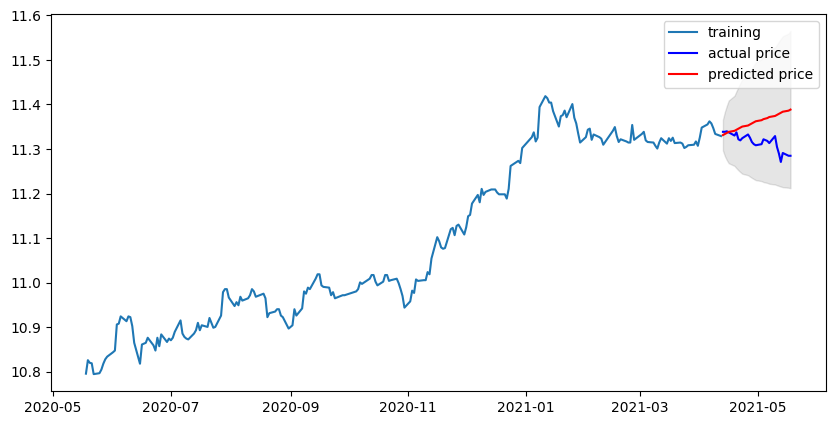

In [47]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


* MAPE 기준으로 4.68%의 낮은 오차율을 보인다.

## 7. 다른 주식 종목 예측해보기

## 1️⃣ Alphabet Inc. (GOOG)

## 데이터 준비

In [51]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/new_data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-08    1532.390015
2020-09-09    1556.959961
2020-09-10    1532.020020
2020-09-11    1520.719971
2020-09-14    1519.280029
Name: Close, dtype: float64

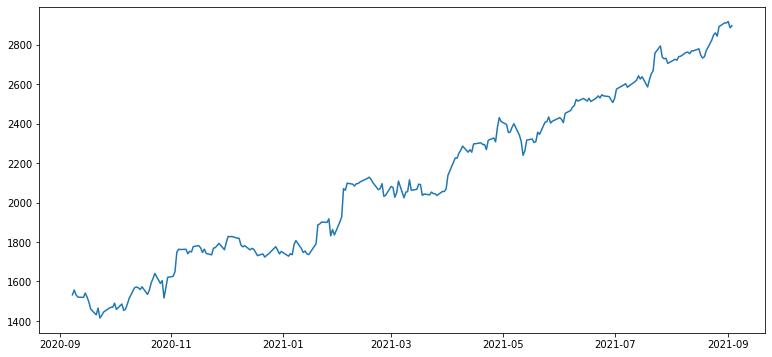

In [52]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

* 평균은 증가하고 분산도 일정하지 않아보인다 => nonstationary

## 각종 전처리 수행

### 결측치 처리

In [53]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없다!

In [54]:
# 결측치가 있을 경우, 결측치 처리 (보간법 사용, 기준 : time)
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

### 로그 변한

In [55]:
# 로그 변환 시도 
ts_log = np.log(ts)

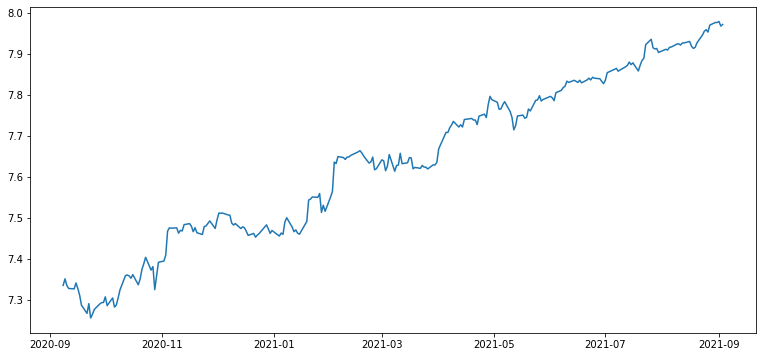

In [56]:
plt.plot(ts_log)

## 시계열 안정성 분석

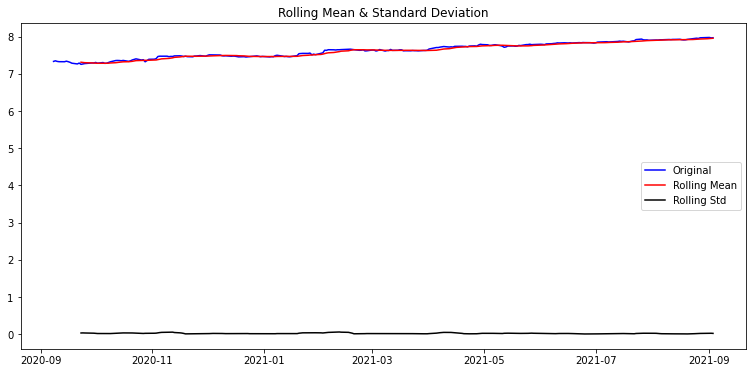

Results of Dickey-Fuller Test:
Test Statistic                  -0.460093
p-value                          0.899572
#Lags Used                       7.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


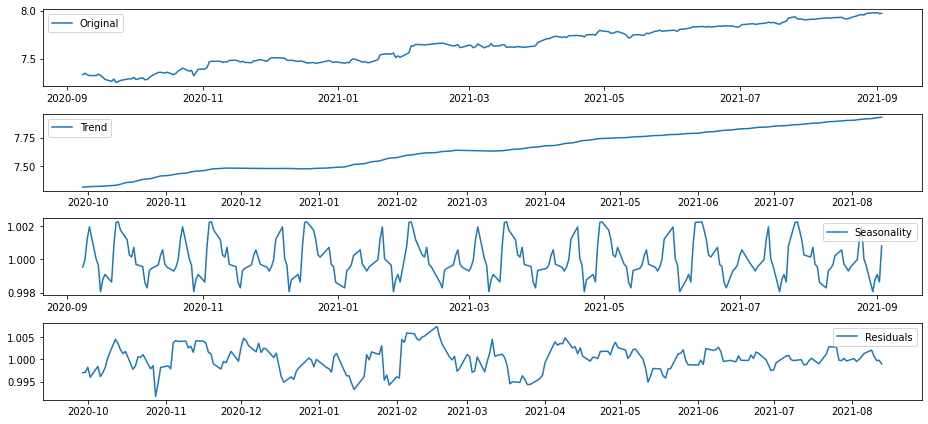

In [57]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [58]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                  -2.754986
p-value                          0.064997
#Lags Used                      15.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64


* p-value가 0.064997로 엄청 낮은 값은 아니다. 만약 alpha=0.05라면 귀무가설을 기각할 수 없으므로 시계열이 안정적이지 않다는 것을 의미한다.

## 학습. 테이스 데이터셋 생성
* 학습, 테스트 데이터셋 분리하기

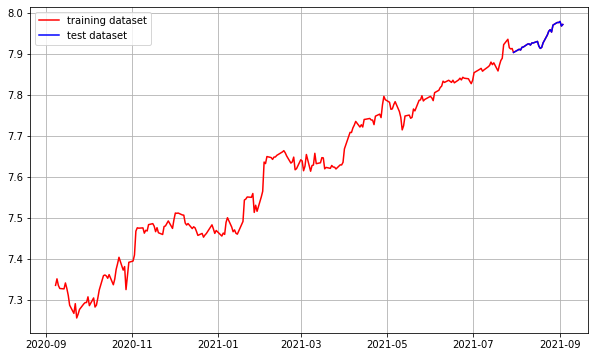

In [59]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [60]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-08    7.334584
2020-09-09    7.350490
Name: Close, dtype: float64
(225,)
(26,)


## 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

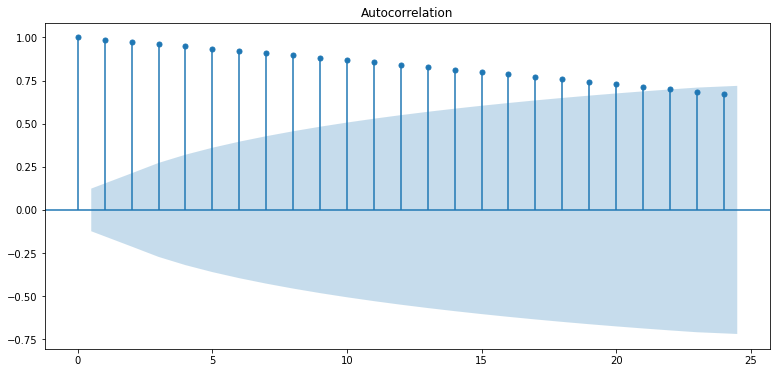

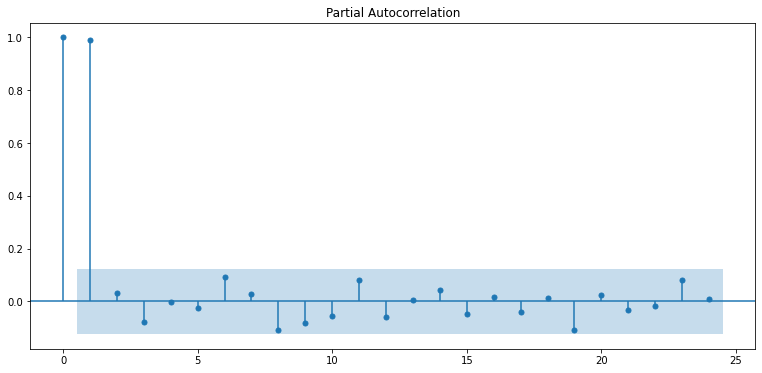

In [61]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF를 보면 일정하게 감소하고 있고, PACF를 보면 lag 1 이후에 갑자기 감소하는 것을 볼 수 있다. 
* AR/MA 모형과 ACF/PACF 관계 표를 보면 위와 같은 패턴은 AR(1)에 유사한 형태를 띄고 있다. 따라서 AR(p),MA(q)이므로 p=1, q=0 로 둘 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -6.586295e+00
p-value                        7.300537e-09
#Lags Used                     6.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.930959e+00
p-value                        1.084448e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


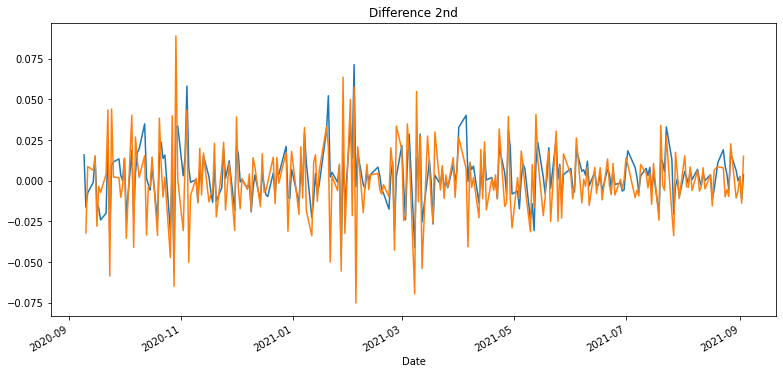

In [62]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* d=1일 때 p-value는 7.300537e-09 로 0에 가까운 값을 가진다. 따라서 d=1로 설정할 수 있다.

## ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [62]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 603.369
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sun, 05 Sep 2021   AIC                          -1200.738
Time:                        06:34:33   BIC                          -1190.503
Sample:                             1   HQIC                         -1196.606
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0026      0.001      2.464      0.014       0.001       0.005
ar.L1.D.Close    -0.0455      0.067     -0.683      0.495      -0.176       0.085
                                    Root

### 모델 테스트 및 플로팅

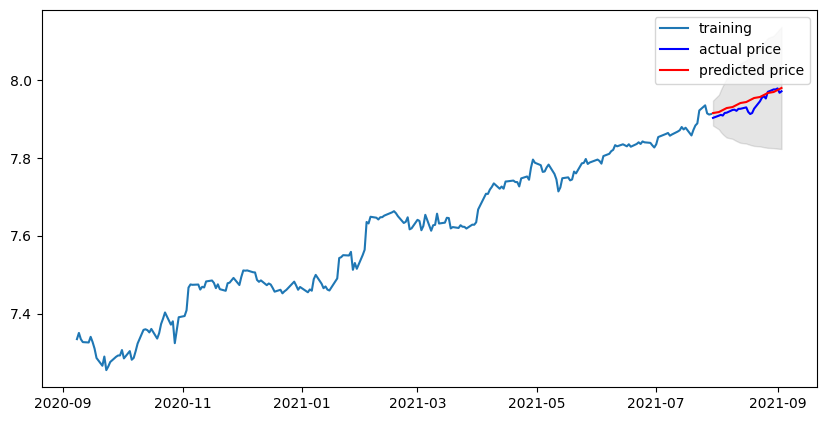

In [63]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1904.1269051311667
MAE:  35.83070718588424
RMSE:  43.63630260610042
MAPE: 1.29%


위의 그래프만 봐도 예측을 잘 한 것을 알 수 있다. MAPE기준으로 1.29%의 엄청 낮은 오차율을 보인다.

## 2️⃣  Doosan Heavy Industries & Construction Co., Ltd. (034020.KS) (두산중공업)

## 데이터 준비

In [5]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/new_data/034020.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    15088.893555
2020-09-08    14292.274414
2020-09-09    13214.497070
2020-09-10    13776.815430
2020-09-11    13917.395508
Name: Close, dtype: float64

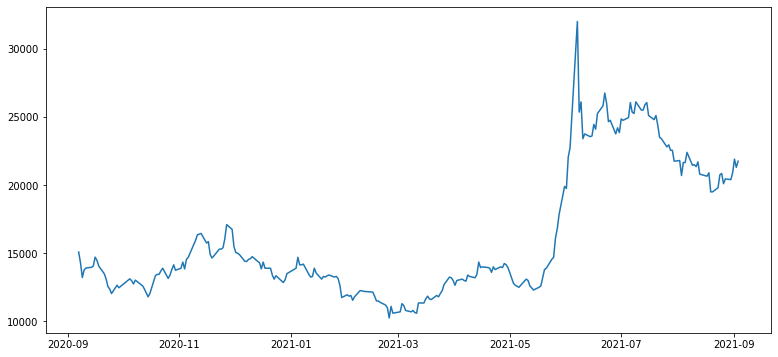

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## 각종 전처리 수행

### 결측치 처리

In [7]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없다!

In [8]:
# 결측치가 있을 경우, 결측치 처리 (보간법 사용, 기준 : time)
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

### 로그 변한

In [9]:
# 로그 변환 시도 
ts_log = np.log(ts)

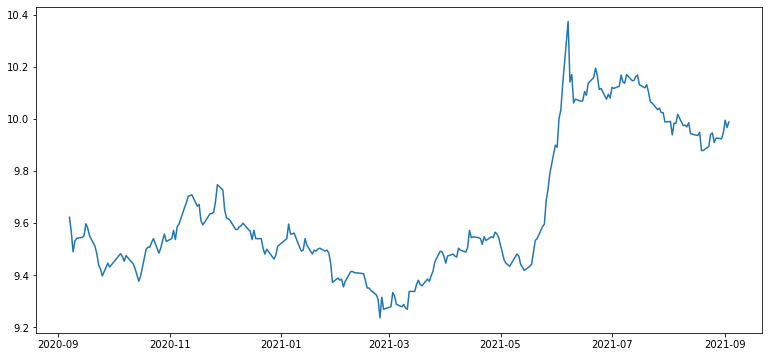

In [10]:
plt.plot(ts_log)

평균과 분산이 일정하지않다 => nonstationary

## 시계열 안정성 분석

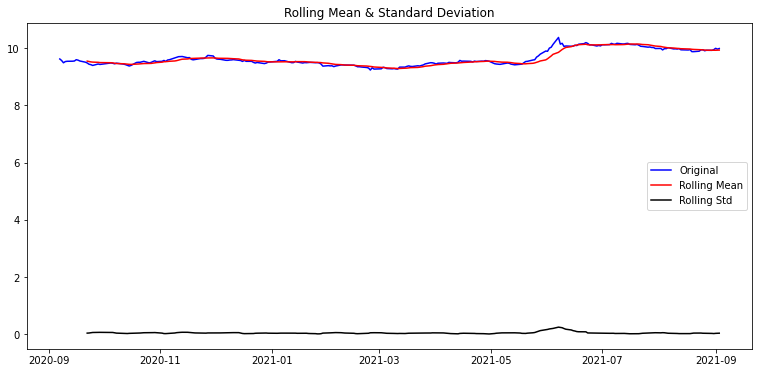

Results of Dickey-Fuller Test:
Test Statistic                  -1.034690
p-value                          0.740403
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


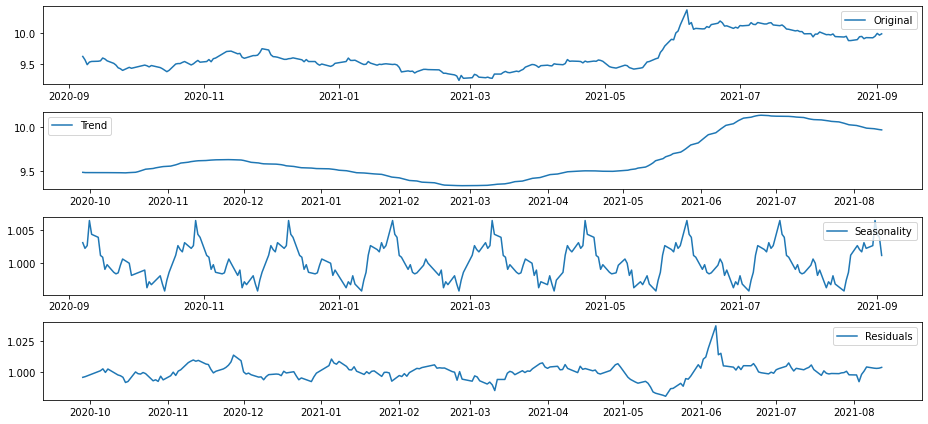

In [11]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [12]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                  -4.227257
p-value                          0.000592
#Lags Used                       8.000000
Number of Observations Used    208.000000
Critical Value (1%)             -3.462186
Critical Value (5%)             -2.875538
Critical Value (10%)            -2.574231
dtype: float64


p-value가 0에 가까우므로 안정적인 시계열이라고 할 수 있다.

## 학습. 테이스 데이터셋 생성
* 학습, 테스트 데이터셋 분리하기

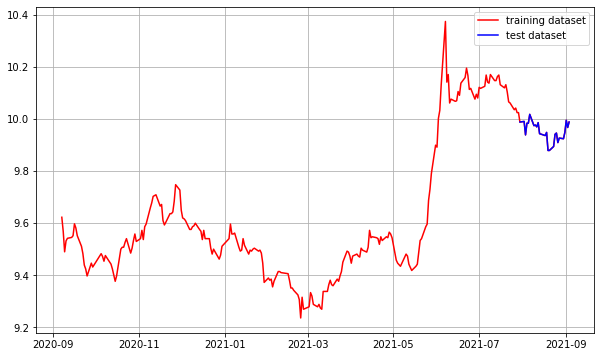

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [14]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-07    9.621714
2020-09-08    9.567474
Name: Close, dtype: float64
(222,)
(25,)


## 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

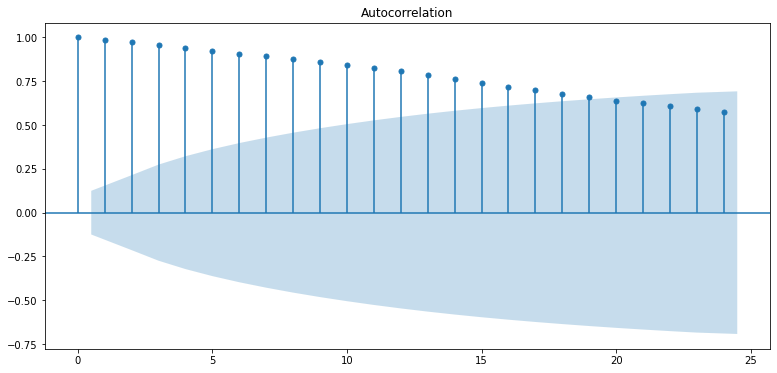

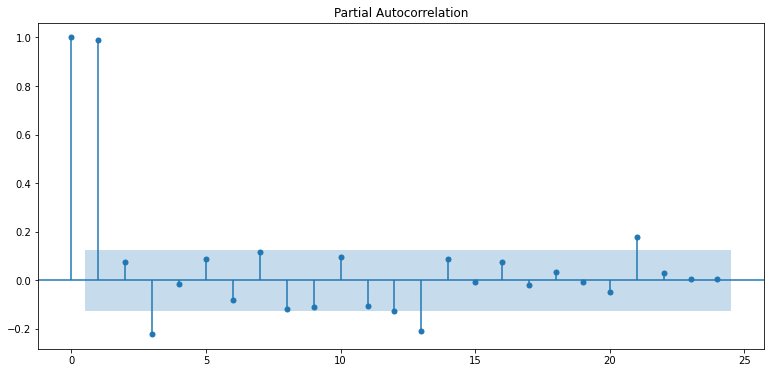

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF를 보면 일정하게 감소하고 있고, PACF를 보면 lag 1 이후에 갑자기 감소하는 것을 볼 수 있다. 
* AR/MA 모형과 ACF/PACF 관계 표를 보면 위와 같은 패턴은 AR(1)에 유사한 형태를 띄고 있다. 따라서 AR(p),MA(q)이므로 p=1, q=0 로 둘 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -9.844968e+00
p-value                        4.645742e-17
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.958261e+00
p-value                        8.359018e-15
#Lags Used                     1.000000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


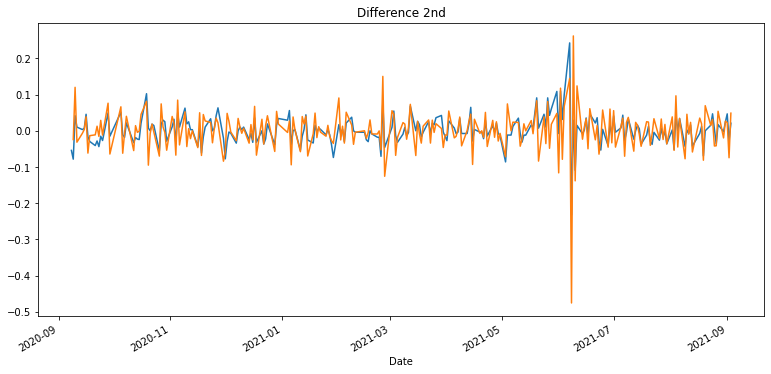

In [16]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차차분만 해도 p-value가 0에 가깝기 때문에 d=1로 둘 수 있다.

## ARIMA 모델 훈련과 테스트

### 💡사실 그래프로 p,d,q를 정하는 것은 주관적이라 여러 경우의 수로 해보면서 평가지표가 가장 좋은것으로 정하는 것도 방법이라고 한다. 
### => 여기선 AIC를 기준으로 보겠다. (값이 0에 가까울수록 좋은 모형을의미)

### ARIMA 모델 빌드와 훈련

### 1. p=1,d=1,q=0이 모수인 ARIMA 모델을 빌드, 훈련 => AIC : -780

In [23]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 393.445
Method:                       css-mle   S.D. of innovations              0.041
Date:                Mon, 06 Sep 2021   AIC                           -780.891
Time:                        14:11:26   BIC                           -770.696
Sample:                             1   HQIC                          -776.774
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0018      0.003      0.703      0.482      -0.003       0.007
ar.L1.D.Close    -0.0538      0.067     -0.800      0.424      -0.186       0.078
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 2. p=1,d=2,q=0이 모수인 ARIMA 모델을 빌드, 훈련 => AIC : - 714

In [24]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model2 = ARIMA(train_data, order=(1, 2, 0))  
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  220
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 360.471
Method:                       css-mle   S.D. of innovations              0.047
Date:                Mon, 06 Sep 2021   AIC                           -714.941
Time:                        14:11:47   BIC                           -704.760
Sample:                             2   HQIC                          -710.830
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.002      0.131      0.896      -0.004       0.004
ar.L1.D2.Close    -0.6086      0.053    -11.451      0.000      -0.713      -0.504
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 3. p=2,d=1,q=0이 모수인 ARIMA 모델을 빌드, 훈련 => AIC : -785

In [25]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model3 = ARIMA(train_data, order=(2, 1, 0))  
fitted_m3 = model3.fit(disp=-1)  
print(fitted_m3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 396.650
Method:                       css-mle   S.D. of innovations              0.040
Date:                Mon, 06 Sep 2021   AIC                           -785.299
Time:                        14:12:50   BIC                           -771.706
Sample:                             1   HQIC                          -779.811
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.003      0.546      0.585      -0.004       0.008
ar.L1.D.Close    -0.0424      0.066     -0.639      0.523      -0.173       0.088
ar.L2.D.Close     0.1708      0.067     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


* p=1,d=2,q=0일때가 AIC가 가장 좋다.

### 모델 테스트 및 플로팅

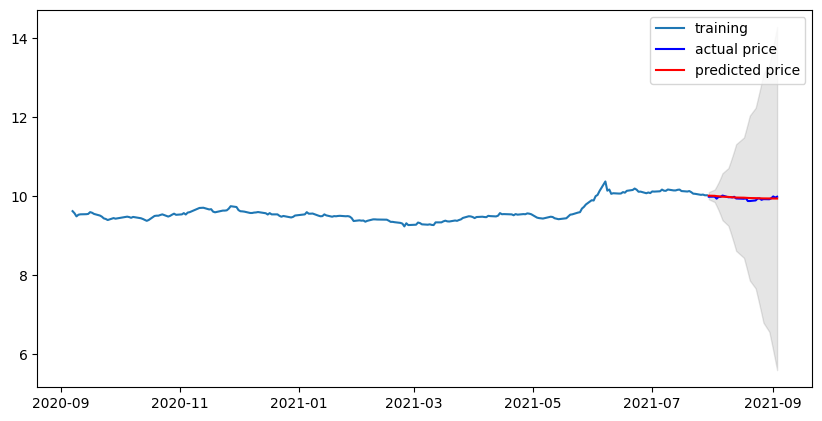

In [26]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m2.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  538553.9021188361
MAE:  574.4001652223919
RMSE:  733.8623182306311
MAPE: 2.78%


* MAPE 기준으로 2.78%이므로 낮은 오차율을 보여준다.

## 3️⃣ LG Display Co., Ltd. (LPL)

## 데이터 준비

In [63]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/new_data/LPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-08    6.65
2020-09-09    6.81
2020-09-10    6.83
2020-09-11    7.09
2020-09-14    7.08
Name: Close, dtype: float64

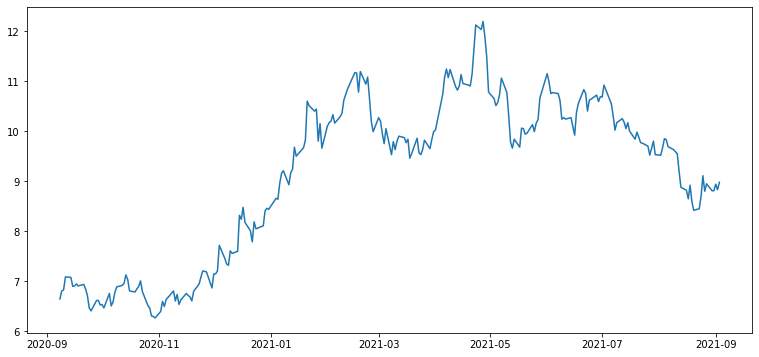

In [64]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## 각종 전처리 수행

### 결측치 처리

In [65]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없다!

In [66]:
# 결측치가 있을 경우, 결측치 처리 (보간법 사용, 기준 : time)
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

### 로그 변한

In [67]:
# 로그 변환 시도 
ts_log = np.log(ts)

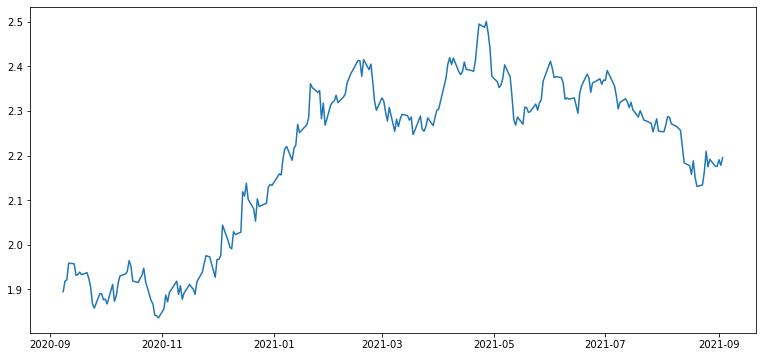

In [68]:
plt.plot(ts_log)

## 시계열 안정성 분석

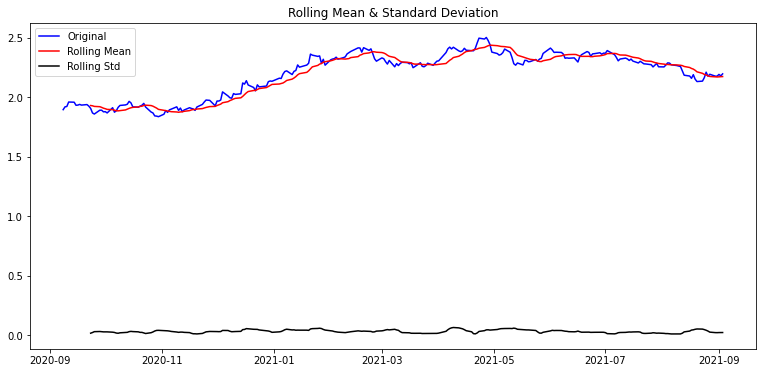

Results of Dickey-Fuller Test:
Test Statistic                  -1.676292
p-value                          0.443367
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


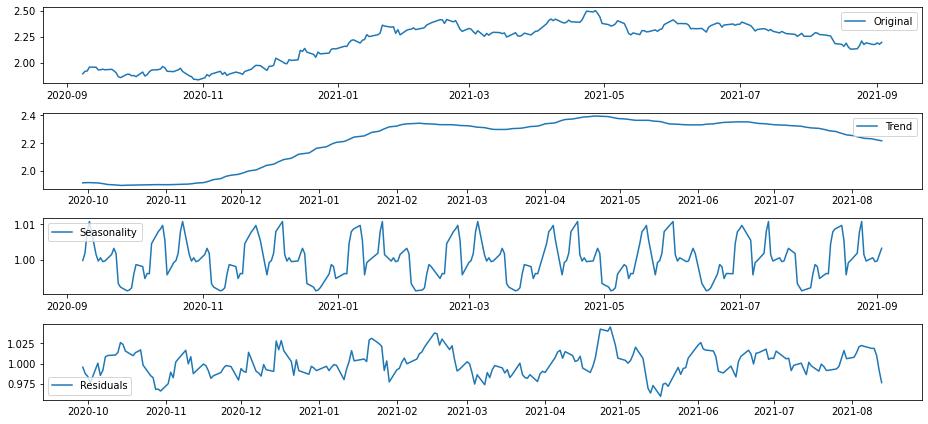

In [69]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [70]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                  -4.267631
p-value                          0.000505
#Lags Used                      13.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


* p-value는 0에 가까우므로 안정적인 시계열이라고 말할 수 있다.

## 학습. 테이스 데이터셋 생성
* 학습, 테스트 데이터셋 분리하기

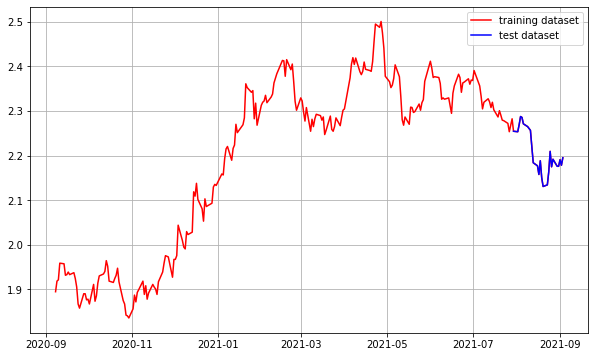

In [71]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [72]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-08    1.894617
2020-09-09    1.918392
Name: Close, dtype: float64
(225,)
(26,)


## 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

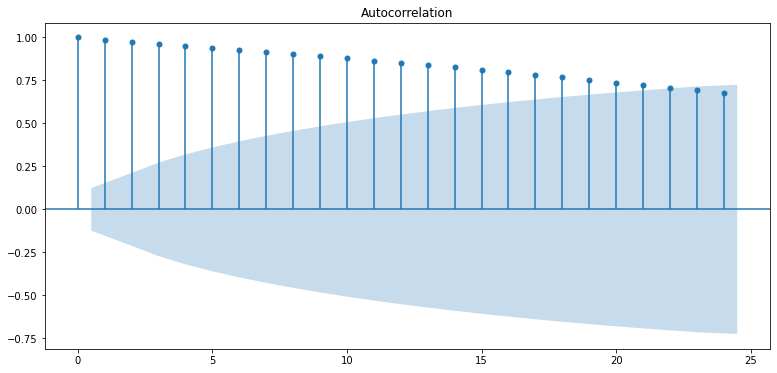

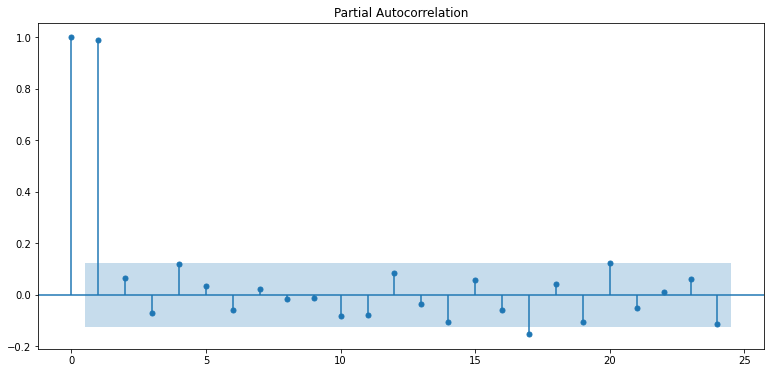

In [73]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF를 보면 일정하게 감소하고 있고, PACF를 보면 lag 1 이후에 갑자기 감소하는 것을 볼 수 있다. 
* AR/MA 모형과 ACF/PACF 관계 표를 보면 위와 같은 패턴은 AR(1)에 유사한 형태를 띄고 있다. 따라서 AR(p),MA(q)이므로 p=1, q=0 로 둘 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.633250e+01
p-value                        3.051169e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.837717e+00
p-value                        1.824406e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


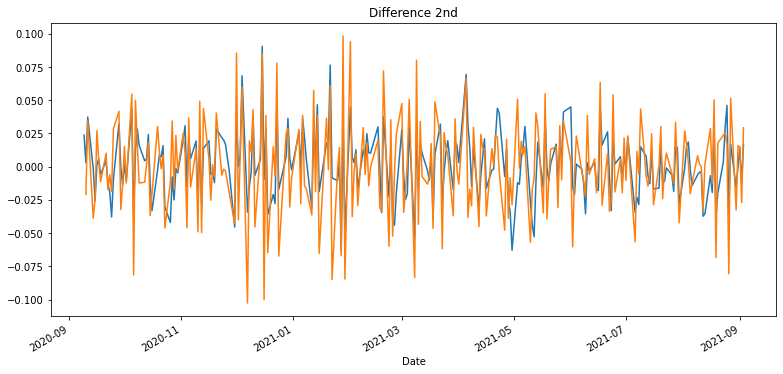

In [74]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* d=1일때도 p-value가 0에 가까우므로 우선 d=1으로 해보겠다.

## ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

### 1. p=1,d=1,q=0인 ARIMA 모델 => AIC : -1011

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 508.506
Method:                       css-mle   S.D. of innovations              0.025
Date:                Mon, 06 Sep 2021   AIC                          -1011.012
Time:                        14:18:00   BIC                          -1000.777
Sample:                             1   HQIC                         -1006.881
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.002      1.073      0.283      -0.001       0.005
ar.L1.D.Close    -0.0389      0.067     -0.583      0.560      -0.170       0.092
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 2. p=1,d=2,q=0인 ARIMA 모델 => AIC : -925

In [75]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model2 = ARIMA(train_data, order=(1, 2, 0))  
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 465.921
Method:                       css-mle   S.D. of innovations              0.030
Date:                Mon, 06 Sep 2021   AIC                           -925.842
Time:                        14:25:26   BIC                           -915.621
Sample:                             2   HQIC                          -921.716
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -8.34e-06      0.001     -0.006      0.995      -0.003       0.003
ar.L1.D2.Close    -0.5573      0.055    -10.074      0.000      -0.666      -0.449
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 3. p=2,d=1,q=0인 ARIMA 모델 => AIC : -1010

In [47]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model3 = ARIMA(train_data, order=(2, 1, 0))  
fitted_m3 = model3.fit(disp=-1)  
print(fitted_m3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 509.273
Method:                       css-mle   S.D. of innovations              0.025
Date:                Mon, 06 Sep 2021   AIC                          -1010.546
Time:                        14:22:15   BIC                           -996.899
Sample:                             1   HQIC                         -1005.037
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.002      0.999      0.318      -0.002       0.005
ar.L1.D.Close    -0.0356      0.067     -0.534      0.593      -0.166       0.095
ar.L2.D.Close     0.0825      0.066     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 4. p=2,d=2,q=0인 ARIMA 모델 => AIC : -938

In [48]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model4 = ARIMA(train_data, order=(2, 2, 0))  
fitted_m4 = model4.fit(disp=-1)  
print(fitted_m4.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 473.109
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 06 Sep 2021   AIC                           -938.219
Time:                        14:23:28   BIC                           -924.590
Sample:                             2   HQIC                          -932.717
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.537e-05      0.001     -0.035      0.972      -0.002       0.002
ar.L1.D2.Close    -0.6971      0.065    -10.772      0.000      -0.824      -0.570
ar.L2.D2.Close    -0.2499      0.065

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p=1,d=2,q=0 일 때의 AIC가 가장 좋다.

### 모델 테스트 및 플로팅

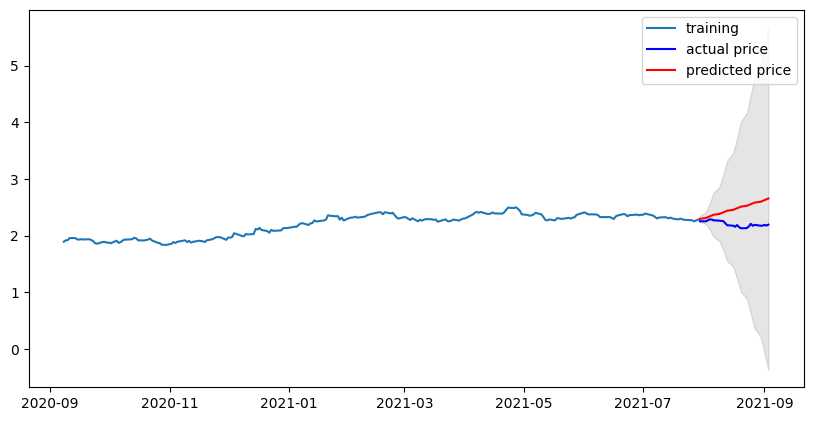

In [82]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m2.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10.85240459851458
MAE:  2.8648552403153693
RMSE:  3.294298802251335
MAPE: 32.23%


p,d,q의 여러 경우의 수를 구해서 모델 선정을 하는 방법을 진행했는데 32.23%로 생각보다 높은 오차율이 나왔다.

### 그렇다면 p=1,d=1,q=0인 ARIMA 모델을 사용하면?

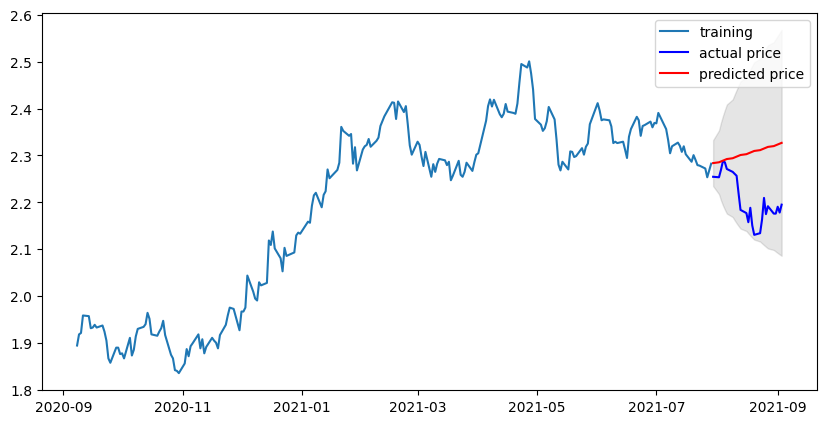

In [84]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.1398124162004888
MAE:  0.9223937496041509
RMSE:  1.0676199774266537
MAPE: 10.43%


* 10.43%로 낮은 오차율이 나왔다. => 1차차분 했을 때의 p-value가 2차차분했을 때의 p-value보다 많이 작아서 그런것일까?

***

# 회고

Youtube 김성범님의 [ARIMA 모델 개요 - Part 1,2](https://www.youtube.com/watch?v=ma_L2YRWMHI) 영상을 보고 공부하였다.

## 1. ACF 패턴을 통해 정상성을 확인할 수 있다

![](https://images.velog.io/images/sjina0722/post/d3110fef-3014-4955-9935-f1dd7985a96d/image.png)

맨 위의 그림을 보면 평균이랑 분산이 일정하다는 것을 쉽게 눈으로 판단할 수 있지만 복잡한 데이터인 경우엔 그래프로 판단하기 어려울 수 있다. <br> => 이때, ACF plot을 통해 패턴을 보고 정상성을 확인해 볼 수 있다!

#### 예제 1)
![](https://images.velog.io/images/sjina0722/post/34da7ac9-8bfc-4e0a-93ea-23766990925f/image.png)

위의 데이터의 autocorrelation을 나타낸 것이 아래의 왼쪽 그래프이다. Nonstationary인 경우에 autocorrelation을 찍어보면 왼쪽 그래프와 같이 천천히 줄어드는 모습이다. 

#### 예제 2)
![](https://images.velog.io/images/sjina0722/post/b611f2b2-12c4-44ed-83ce-9e93d266a196/image.png)

위의 그래프는 증가하는 경향이 보이고 분산도 바뀌는 대표적인 nonstationary 이다. autocorrelation을 찍어보면 떨어졌다 올라갔다하지만 전반적으로 떨어지는 패턴을 보인다. 이런 패턴 역시 nonstationary에서 볼 수 있는 패턴이다.

**< ACF를 통해서 정상성을 알아보는 방법 정리 >**
* 일정한 패턴이 없거나 갑자기 떨어지는 패턴 => stationary
* 일정하게 떨어지거나 올라갔다 내려갔다하면서 굉장히 천천히 떨어지는 패턴 => nonstationary

## 2. AR, MA, ARMA 이 모델들을 구현하기 위해서는 분석해야되는 데이터가 stationary해야된다. <br> => nonstationary를 stationary로 바꿔주는 간단한 방법이 바로 differencing(차분)!

### 차분 : 현 시점 데이터에서 d시점 이전 데이터를 뺀 것
![](https://images.velog.io/images/sjina0722/post/dd685970-0654-48a3-aaa2-9c60c68d5d7b/image.png)

![](https://images.velog.io/images/sjina0722/post/367bbe12-7caf-437d-9927-ecfeebd62863/image.png)
* 1차 차분이란 t시점의 데이터와 t-1시점의 데이터의 차이
* 2차 차분이란 t시점의 데이터와 t-2시점의 데이터의 차이
* d차 차분이란 t시점의 데이터와 t-d시점의 데이터의 차이

**X(원래 데이터)는 nonstationary여도 differencing을 한 결과(Y)는 stationary로 바뀔 확률이 매우 크다**

## 3. 대부분의 데이터가 2차 차분으로 충분하다.

![](https://images.velog.io/images/sjina0722/post/1e6dacb7-3b28-46d1-b79c-3045f7d78396/image.png)
* 만약 original 데이터가 stationary이면 differencing은 필요없다.
* 만약 original 데이터가 constant average trend(일정하게 증가하거나 감소하는 패턴)이면 1차 차분이면 충분하다.
* 아래쪽의 그래프와 같이 더 복잡한 패턴을 가지고 있다면 2차 차분까지 가야된다.
* **대부분의 데이터가 2차 차분으로 충분하다.**
* 3차 차분까지 했을 때 stationary가 되는 데이터는 AR,MA,ARMA 모델로는 적합하지 않은 데이터라고 생각하면 됨.

## 4. ACF 패턴

![](https://images.velog.io/images/sjina0722/post/7603265c-100c-4c1f-a7c4-50c3f4cf5428/image.png)
* (a) : lag 2 이후에 확 감소한다. (Cut off)
* (b) : 지수적으로 천천히 감소 (Die out/Die down)
* (c) : sine함수 모양으로 감소 (Die out/Die down)
* (d) : 0을 기준으로 + - 왔다갔다 하면서 점차적으로 줄어드는 경우 (Die out with osciliation)

## 5. Box-Jenkins ARIMA Procedure
![](https://images.velog.io/images/sjina0722/post/c3efe79c-417b-4ff6-a693-f4ad2ac7dd7a/image.png)

* ARIMA 모델 구현하는 순서이다.<br>

1) 데이터 전처리 (데이터가 nonstationary일 때, transformation이나 differencing을 이용해서 stationary하게 만듦) <br>

2) 시범적으로 해볼 모델을 선정<br>
![](https://images.velog.io/images/sjina0722/post/e8fc0b78-cc11-4dab-b6c8-fa60021e4552/image.png)<br>
* MA, AR ,ARMA 모델 중 뭘로 할지 정해야 된다.
	- MA모델을 선택하는 경우 : ACF는 lag q 이후에 절단되는 패턴을 보임/PACF는 천천히 감소 하는 패턴을 보일 때
	- AR모델을 선택하는 경우 :PACF이 lag p 이후에 확 떨어지고 ACF가 지수적으로 감소 or sine함수 형태로 소멸할 때
	- ARMA모델은 선택하는 경우 : ACF와 PACF가 (q-p)시점 이후부터 떨어질 때<br>
    
3) 파라미터 추정<br>
* p,d,q를 그래프를 보고 결정할수도 있지만 이 방법을 써서 패턴이 보이지 않는 경우도 있다. <br>
=> 이럴땐 여러 경우의 수로 돌려보고 평가지표가 좋은 것으로 선택한다. (예를 들어 AIC가 제일 좋은것)<br>

4) 모델이 괜찮은지 체크 => 괜찮지 않다면 2번 스텝으로<br>

5) 예측하기

## 느낀점
* 시계열 개념이 생소해서 이해하는데 오래 걸렸다.
* 아직도 다 이해가 된 건 아니여서 더 공부해야겠다..
* 통계공부를 해야될 것 같다...!! 